<a href="https://colab.research.google.com/github/jenajjedu/NLP_Named_Entities/blob/main/Copy_of_PA7_3_GPT_2Ghalia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GPT-2 Fine-Tuning Tutorial using raw text corpus

From Rey Farhan (https://reyfarhan.com/posts/easy-gpt2-finetuning-huggingface/)




This is a simplified script for fine-tuning GPT2 using Hugging Face's [Transformers library](https://huggingface.co/transformers/) and PyTorch on raw data. 

---------
Your task is to modify this assignment on raw text of your choice (I have put Pride and Prejudice as an example below) and include 10 sample generations from your chosen text that you find interesting. 


# Setup

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 14.6 MB/s 
     |████████████████████████████████| 7.6 MB 68.9 MB/s 
     |████████████████████████████████| 182 kB 56.8 MB/s 


In [ ]:
import os
import time
import datetime
from google.colab import drive

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
!nvidia-smi

Fri Dec  9 21:59:08 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P0    30W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Create Training Set


In [ ]:
# mount my Google Drive directory and access the training data located there
gdrive_dir = '/content/gdrive/'
data_dir = os.path.join(gdrive_dir, "'My Drive'")
filename = 'prideAndPrejudice.txt'

drive.mount(gdrive_dir, force_remount=True)


Mounted at /content/gdrive/


In [ ]:
# copy the data to the current Colab working directory
!cp $data_dir/$filename .

cp: cannot stat '/content/gdrive/My Drive/prideAndPrejudice.txt': No such file or directory


In [ ]:
f=open(filename)
docs=f.readlines()
docs=[b.strip() for b in docs]
docs[:5]

['It is a truth universally acknowledged, that a single man in possession of a good fortune, must be in want of a wife.',
 'However little known the feelings or views of such a man may be on his first entering a neighbourhood, this truth is so well fixed in the minds of the surrounding families, that he is considered the rightful property of some one or other of their daughters.',
 '"My dear Mr. Bennet," said his lady to him one day, "have you heard that Netherfield Park is let at last?"',
 'Mr. Bennet replied that he had not.',
 '"But it is," returned she; "for Mrs. Long has just been here, and she told me all about it."']

We need to get an idea of how long our training documents are.

I'm not going to use the same tokenizer as the GPT2 one, which is a [byte pair encoding tokenizer](https://blog.floydhub.com/tokenization-nlp/). Instead, I'm using a simple one just to get a rough understanding.

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


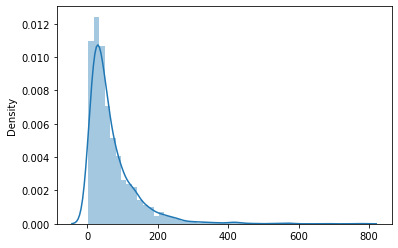

In [ ]:
doc_lengths = []

for doc in docs:

    # get rough token count distribution
    tokens = nltk.word_tokenize(doc)

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.distplot(doc_lengths)

In [ ]:
# the max token length   
len(doc_lengths[doc_lengths > 768])/len(doc_lengths)

0.0004847309743092584

In [ ]:
np.average(doc_lengths)

69.48763936015511

Even though these token counts won't match up to the BPE tokenizer's, I'm confident that most lines will be fit under the 768 embedding size limit for the small GPT2 model.

# GPT2 Tokenizer

Although the defaults take care of this,I thought I'd show that you can specify some of the special tokens. 

In [ ]:
# Load the GPT tokenizer.
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium


Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

The max model length is 1024 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token <|startoftext|> token has the id 50257
The end of sequence token <|endoftext|> has the id 50256
The padding token <|pad|> has the id 50258


# PyTorch Datasets & Dataloaders


GPT2 is a large model. Increasing the batch size above 2 has lead to out of memory problems. This can be mitigated by accumulating the gradients but that is out of scope here.

In [ ]:
batch_size = 2

I'm using the standard PyTorch approach of loading data in using a [dataset class](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

I'm passing in the tokenizer as an argument but normally I would  instantiate it within the class.

In [ ]:
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=768):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:

      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx] 

To understand how I've used the tokenizer, it's worth reading [the docs](https://huggingface.co/transformers/main_classes/tokenizer.html). I've wrapped each line in the bos and eos tokens.

Every tensor passed to the model should be the same length.

If the line is shorter than 768 tokens, it will be padded to a length of 768 using the padding token. In addition, an attention mask will be returned that needs to be passed to the model to tell it to ignore the padding tokens. 

If the line is longer than 768 tokens, it will be truncated without the eos_token. This isn't a problem.

In [ ]:
dataset = GPT2Dataset(docs, tokenizer, max_length=768)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

1,856 training samples
  207 validation samples


In [ ]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# Finetune GPT2 Language Model

In [ ]:
# I'm not really doing anything with the config buheret
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# instantiate the model
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

Downloading:   0%|          | 0.00/548M [00:00<?, ?B/s]

In [ ]:
# some parameters I cooked up that work reasonably well

epochs = 5
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [ ]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [ ]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    928. Loss: 0.4385337233543396.   Elapsed: 0:00:55.
0:  bipartisan" But she took it as a mistake.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    928. Loss: 0.2442033886909485.   Elapsed: 0:01:46.
0:  increasing_reborn_in_town. Lance of Kent, Colonel, said Colonel Pemberley, "I am determined to stay. My father has been gone." Elizabeth and Bingley were very fond of her father, though no longer so dear. Bingley was still at Netherfield for the next day; Elizabeth was at Netherster for the next day. As soon as she heard that Elizabeth was gone, Colonel Pemberley went into the house without being seen, and Elizabeth returned to Netherfield on this account; but she would not be able to help them, without making a stand. Mr. Collins was not surprised; but he saw very little reason to believe that her brother could not know what Colonel Pcy would be all day for them. Long, and many many inquiries ensued, and he could tell nothing of that he was all too eagerly for Mrs. Bennet, who, however, she could tell, did not allow it to get any more. Colonel P


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    928. Loss: 0.3474106788635254.   Elapsed: 0:02:40.
0: day an inclination of Mr. Darcy's mother, in speaking of her, and in talking with them, and in talking with them of her, and in talking with them again for weeks, weeks, or weeks, nothing happened. Lydia was a little angry to have mentioned Miss Bennets, which she had already mentioned to Jane."


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    928. Loss: 0.36857858300209045.   Elapsed: 0:03:31.
0:  Hang the very day of the dinner, Elizabeth attended the table with a lady whom she admired, and took care of her. She looked forward to a pleasant discourse in a hall, which she did not hesitate to follow as soon as she was ready. Elizabeth began to comprehend what had passed, and was surprised at the sight of Mr. Benn, who turned away, and stared him down to her with an expression of pleasure in his eyes. The whole party followed him out. When a lady's opinion of them was expressed as soon as he passed from the table in the evening, the two girls seemed to take on a much greater part. The room was exceedingly happy for them. Elizabeth had always liked her family, she thought, and always hoped to be able to enjoy them. It was as much their enjoyment in her family as the evening after breakfast, and was the first time in a twelvemonth period where it was not at a distance from the dance; Jane had often thought 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of    928. Loss: 0.31373029947280884.   Elapsed: 0:04:24.
0:  foods"He is the friend of every one of his family, and will certainly give such thanks. We have the most superior and most important family; and we are as well-known for it in the world.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of    928. Loss: 0.17528805136680603.   Elapsed: 0:05:16.
0:  trail"Yes, Lady Catherine, I shall not take away the credit of having spoken to you during my letter to Colonel Bingley at Brighton, and my desire for a better relations in our house will not allow it to be so. In the whole business I shall not be surprised at what you tell me by it. I shall be glad to hear from you. What is your feelings of Miss Hurst, Mrs. Darcy? Do they have all of the right opinions? Do we not agree with them?"


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of    928. Loss: 0.28156453371047974.   Elapsed: 0:06:07.
0: intend"As I always felt that it should not be such a thing, I knew it was no such thing," said Mrs. Bennet. "Your situation, your dear wife's iniquity, and your behaviour towards your daughter, your husband's inactivity with him is, I think, the reason on which your family's pride was continually expressed in the name of Mr. Bingley."


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of    928. Loss: 0.3062777519226074.   Elapsed: 0:06:59.
0:  surround"I really dislike your opinion of yourself, and have scarcely spoken much of it. I cannot remember what the manners of that other woman in town had been. I think, however, I shall be sure you have been very handsome; but my relations are very handsome, and are quite agreeable to Mrs. Forster."


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of    928. Loss: 0.28712767362594604.   Elapsed: 0:07:51.
0:  reflex_will, however, should not have prevented her from saying that his father could not but see no evil. Mr. Bennet did not like to dance with him so much, except with a few slight accents. He could not play at them, but he was not much in love with either, and they were not to have a great advantage in dancing.

  Average training loss: 0.51
  Training epoch took: 0:08:06

Running Validation...
  Validation Loss: 0.32
  Validation took: 0:00:17

======== Epoch 2 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    928. Loss: 0.0804130807518959.   Elapsed: 0:00:51.
0:  display"I am sorry you did not tell me so much; but, Mr. Collins, I trust I will do my utmost."


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    928. Loss: 0.16789597272872925.   Elapsed: 0:01:43.
0:  pastor"You are very kind and generous. Miss Eliza is the very same."


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    928. Loss: 0.1332893669605255.   Elapsed: 0:02:35.
0:  illicit"I will not have so little. You will only lose the whole point. But I believe Lady Catherine might still make some mistakes, as Jane would, by marrying you."


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    928. Loss: 0.4798473119735718.   Elapsed: 0:03:26.
0:  Liberation"If a young man were to ask him what his feelings were then, he would not immediately know."


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of    928. Loss: 0.507871687412262.   Elapsed: 0:04:18.
0:  NamThe weather was beautiful, and every evening passed very pleasantly as usual, except on the day of her daughter's absence. But when they were gone, Elizabeth, with the girls, did not hear much; and on her leaving Netherfield, she could not help saying that she was very sorry that Bingley had not seen them again. She thought of her daughter only as Jane to Jane; and with the last of her girls, with Mrs. Hurst, was forced to leave Netherfield altogether.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of    928. Loss: 0.11060294508934021.   Elapsed: 0:05:10.
0: ION"My dear aunt, I must confess, that I saw as you probably did, and thought myself persuaded of your excellent understanding, if I had known, before my death, that what is to be done in the militia?"


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of    928. Loss: 0.2488270103931427.   Elapsed: 0:06:02.
0:  glimpse"I shall not speak of it till your letter is finished. It will not be in the country; but _that_ shall _never_ be the case. When you tell them to come, we shall not know which will be their family. The whole party will depend upon it. I must depend on it as much as possible. Every man lives to have a son, and nothing is certain about their being married. You tell me what shall happen to _your_ family."


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of    928. Loss: 0.17716871201992035.   Elapsed: 0:06:55.
0:  Laure"This is a proof that he is not a young man. We both know that he likes to stay up long after he has seen much of the neighbourhood."


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of    928. Loss: 0.11517711728811264.   Elapsed: 0:07:46.
0: ism"And would it be reasonable to hope that the officers themselves are superior to the officers? And would it be reasonable to suppose that their officers should not do the same?"

  Average training loss: 0.30
  Training epoch took: 0:08:01

Running Validation...
  Validation Loss: 0.32
  Validation took: 0:00:17

======== Epoch 3 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    928. Loss: 0.4905364513397217.   Elapsed: 0:00:52.
0: oun"But what did he do, pray?" said Elizabeth; "I am afraid he ought to be gone."


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    928. Loss: 0.17922765016555786.   Elapsed: 0:01:43.
0:  election"A little more of the house!" cried Maria. "He is not welcome at Netherfield. Your mother says that he must not come to see us."


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    928. Loss: 0.1902550756931305.   Elapsed: 0:02:35.
0:  crazy"This is not to be taken for an attention."


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    928. Loss: 0.421204537153244.   Elapsed: 0:03:27.
0:  bench"I certainly am. But you must know, my dear, that my daughters have been very little affected by us. I was only a fortnight or two from my entrance in Hertfordshire. Their father is dead. How is it possible that he should not be gone so soon as he did so well?"


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of    928. Loss: 0.110977403819561.   Elapsed: 0:04:19.
0:  incorporated"In spite of all the disadvantages which might sometimes occur, I am sure I did not suffer from the same pains. I did not hear my brother mentioned three times by Mr. Gardiner; but to be sure there were many more, it would have been much better had he not done it, if he had done it before. A little to the matter of Miss de Bourgh's appearing the way she is, I believe it may have been better. Her being seen, however, is one of the few circumstances where it can do justice to the feelings which he inspires."


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of    928. Loss: 0.19973978400230408.   Elapsed: 0:05:12.
0: Peter"But we must keep a very good countenance and keep a very reasonable eye on the picture. If it contains any part of a lady's figure, let it be the result."


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of    928. Loss: 0.27503153681755066.   Elapsed: 0:06:04.
0: uringElizabeth was so much in love with Miss Bingley, she was unable to give up the letter without a denial; and as this answered her question, she immediately put it into her pocket-book. Mr. Darcy, who was writing with his sister, read it with great pleasure; and shortly afterwards added, "You are quite mistaken."


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of    928. Loss: 0.09476561099290848.   Elapsed: 0:06:56.
0:  reproductive"You are to-morrow," said he, "and I must do it very well."


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of    928. Loss: 0.23438940942287445.   Elapsed: 0:07:48.
0:  zoneIt was very well done, and Mr. Collins was standing close enough to his sisters to hear the conversation.

  Average training loss: 0.26
  Training epoch took: 0:08:02

Running Validation...
  Validation Loss: 0.33
  Validation took: 0:00:17

======== Epoch 4 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    928. Loss: 0.65650475025177.   Elapsed: 0:00:52.
0:  commits"Certainly, not to be imputed to his being the son of a very respectable man himself, he could not be so remarkably clever and agreeable. But I am not so easily blind to the folly and dishonour of his father's pride as to suppose that he could have foreseen anything so bad or so bad as this!"


KeyboardInterrupt: ignored

Let's view the summary of the training process.

In [ ]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

In [ ]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# Display Model Info

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

# Saving & Loading Fine-Tuned Model


In [ ]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


In [ ]:
!ls -l --block-size=K ./model_save/

In [ ]:
!ls -l --block-size=M ./model_save/pytorch_model.bin

In [ ]:
# Copy the model files to a directory in your Google Drive.
!cp -r ./model_save/ $data_dir

# # Load a trained model and vocabulary that you have fine-tuned
#model = GPT2LMHeadModel.from_pretrained(output_dir)
#tokenizer = GPT2Tokenizer.from_pretrained(output_dir)
#model.to(device)

# Generate Text

In [ ]:
model.eval()

prompt = "<|startoftext|>"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
                                generated, 
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,   
                                top_k=50, 
                                max_length = 300,
                                top_p=0.95, 
                                num_return_sequences=3
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

These aren't bad at all! Now train the model on your chosen raw text that is roughly comparable in size to pride and prejudice. 

(5 pts) Draw a figure for tracking train and validation losses. 

(5 pts) Print out some sample text from your chosen data and report 10 example generations that you think are interesting! Do your examples look like your training text?


> YOUR ANSWER HERE